<a href="https://colab.research.google.com/github/BU0x01/Quantitative-finance/blob/main/Quantitative_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['VLTO', 'SOLV', 'GEV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375292   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718929   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145813   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.253998   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017853  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717102  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[984472 rows x 6 columns]

In [5]:
! pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=8e3bdb84c71cfc08894935d03bbd3f0148b75443f8caabc55e07d547c5ec154e
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [7]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375292   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595573   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718929   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145813   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.253998   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017853  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717102  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001156        NaN       NaN   
           AAPL    293461600.0         -0.005949        NaN       NaN   
           ABBV     12842800.0         -0.059780        NaN       NaN   
           ABT      12287500.0         -0.010671        NaN       NaN   
           ACGL      1888800.0          0.000068        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000107  26.146728  4.480372   
           YUM       1500600.0         -0.000213  36.057219  4.801976   
           ZBH       3610500.0         -0.000058  31.893223  4.743683   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000032  42.623432  5.151393   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.669707  
           AAPL         NaN       NaN       NaN       NaN    7217.856330  
           ABBV         NaN       NaN       NaN       NaN     458.731065  
           ABT          NaN       NaN       NaN       NaN     407.279177  
           ACGL         NaN       NaN       NaN       NaN      46.118202  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.562291  4.644210  0.033800 -2.159189     116.707087  
           YUM     4.831939  4.861902  0.142547 -1.363695     181.599390  
           ZBH     4.783349  4.823015 -0.381708 -0.881067     401.803403  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.210205  5.269017  0.651515 -1.188279     255.646064  

[984472 rows x 14 columns]

In [8]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525155   38.888977         -0.002190  73.421397   
           AAPL      4014.914536   26.793615         -0.003473  55.537351   
           ABBV       331.841274   39.708744         -0.064880  49.376855   
           ABT        209.554446   37.912804         -0.012576  56.962635   
           ACGL        29.629264   24.156668          0.000078  35.682541   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000          0.000214  41.544692   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.304722  107.661491          0.000080  55.245470   
           GEHC       212.127123   66.083878          0.000184  40.922331   
           KVUE       664.360306   19.814009         -0.000410  35.706331   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.542646  3.615088  3.687529 -1.033887  0.567156  
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142789  
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145676  
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335557  
           ACGL    3.226274  3.243525  3.260776 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366877  
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116463  
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435621  

[46483 rows x 9 columns]

In [9]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.153399         -0.002611  49.891131  3.292064   
           ABBV     39.562851         -0.051416  27.477789  3.736752   
           ABT      33.952477         -0.008608  38.008858  3.544926   
           ACN     102.699364         -0.005389  53.823610  4.628986   
           ADBE    107.510002          0.000059  53.668389  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.320942  3.349819 -1.038688 -0.195978  
           ABBV    3.790895  3.845038 -0.893132 -0.760594  
           ABT     3.595386  3.645846 -1.035224 -0.650887  
           ACN     4.640623  4.652259 -0.996806 -0.135457  
           ADBE    4.694639  4.709766 -1.230331 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [10]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.624390         -0.001153  69.196681  3.592536   
           ABBV     66.346985         -0.038051  55.247851  4.179863   
           ABT      48.011189         -0.006128  53.844905  3.882779   
           ACN     128.312408         -0.004612  69.365042  4.794306   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.639405  3.686275 -0.906642 -0.039275   0.096808   
           ABBV    4.226212  4.272562  0.375557  0.473815   0.022728   
           ABT     3.906344  3.929909 -1.040044  0.276132   0.021275   
           ACN     4.833983  4.873660 -0.986514  0.352343   0.064180   
           ADBE    5.089292  5.226825 -0.888269  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10344 rows x 14 columns]

In [12]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WDAY   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.062413
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[8289 rows x 6 columns]

In [13]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WDAY   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.062413
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000676
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[8252 rows x 6 columns]

In [14]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.328191 -0.159646  0.257548  0.321768  0.107619
           WDAY    1.088836 -0.923652 -0.538565 -0.910245 -0.238841
           WFC     1.112946  0.306860  2.044024 -0.451833 -1.511410
           WMT     0.703219 -0.309966 -0.427673 -0.156623  0.526860
           XOM     0.974446 -1.078104  1.740530 -0.633261 -0.367964

[8252 rows x 5 columns]

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8022 entries, (Timestamp('2018-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  8022 non-null   float64
 1   rsi               8022 non-null   float64
 2   bb_low            8022 non-null   float64
 3   bb_mid            8022 non-null   float64
 4   bb_high           8022 non-null   float64
 5   atr               8022 non-null   float64
 6   macd              8022 non-null   float64
 7   return_1m         8022 non-null   float64
 8   return_2m         8022 non-null   float64
 9   return_3m         8022 non-null   float64
 10  return_6m         8022 non-null   float64
 11  return_9m         8022 non-null   float64
 12  return_12m        8022 non-null   float64
 13  Mkt-RF            8022 non-null   float64
 14  SMB               8022 non-null   float64
 15  HML        

In [25]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init= 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-10-31 AAPL           -0.000474  50.232898  3.936273  3.974637  4.013001   
           ABBV           -0.035686  30.334039  4.092051  4.213714  4.335376   
           ABT            -0.003673  51.539068  4.103887  4.145891  4.187896   
           ACN            -0.002060  44.756094  4.926108  4.990820  5.055531   
           ADBE            0.000288  46.518480  5.452778  5.520491  5.588203   
...                             ...        ...       ...       ...       ...   
2023-09-30 VZ             -0.002576  42.222505  3.436867  3.469043  3.501219   
           WDAY            0.000141  43.976804  5.437299  5.495242  5.553185   
           WFC            -0.000503  40.920298  3.684032  3.724383  3.764733   
           WMT            -0.000103  54.722588  3.980011  3.997479  4.014947   
           XOM            -0.000205  59.440198  4.679146  4.719239  4.759332   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-10-31 AAPL   -0.265596 -0.447839  -0.030478  -0.019453   0.048955   
           ABBV    0.530626 -1.979973  -0.168082  -0.090324  -0.051576   
           ABT    -0.049420 -0.515301  -0.056387   0.017674   0.018393   
           ACN    -0.205759 -1.025608  -0.065449  -0.030053  -0.000564   
           ADBE    0.465853 -0.757222  -0.089609  -0.034267   0.001469   
...                     ...       ...        ...        ...        ...   
2023-09-30 VZ     -1.078816 -0.350385  -0.056890  -0.016122  -0.033458   
           WDAY   -0.127668 -0.306858  -0.062413  -0.016777   0.004919   
           WFC    -0.558742 -0.282324  -0.015500  -0.057917  -0.013554   
           WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-10-31 AAPL     0.049216   0.031518    0.023037  1.334387 -0.391350   
           ABBV    -0.031893  -0.036005   -0.009087  0.566726  0.476001   
           ABT      0.030307   0.013075    0.021747  0.772717 -0.097963   
           ACN      0.008483  -0.000163    0.010026  1.218918 -0.150898   
           ADBE     0.017396   0.023294    0.028623  1.182835 -0.444383   
...                      ...        ...         ...       ...       ...   
2023-09-30 VZ      -0.021495  -0.014100   -0.006158  0.297791 -0.204295   
           WDAY     0.017531   0.035597    0.034709  1.086959 -0.939050   
           WFC      0.016712   0.000703    0.003255  1.130268  0.322854   
           WMT      0.017574   0.016553    0.020256  0.743589 -0.256691   
           XOM      0.012838   0.008747    0.027037  0.998273 -1.035812   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-10-31 AAPL   -0.691821  0.447808  0.775388        0  
           ABBV   -0.206374  0.519055  0.428342        2  
           ABT    -0.473796  0.250041  0.936082        0  
           ACN    -0.260878  0.453805  0.099436        1  
           ADBE   -0.309952  0.273058 -0.507157        0  
...                     ...       ...       ...      ...  
2023-09-30 VZ      0.332908  0.327693  0.003598        1  
           WDAY   -0.550899 -0.857819 -0.252835        1  
           WFC     1.988388 -0.416300 -1.457798        3  
           WMT    -0.535832 -0.139712  0.661391        2  
           XOM     1.691267 -0.667953 -0.282062        2  

[8022 rows x 19 columns]

In [26]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

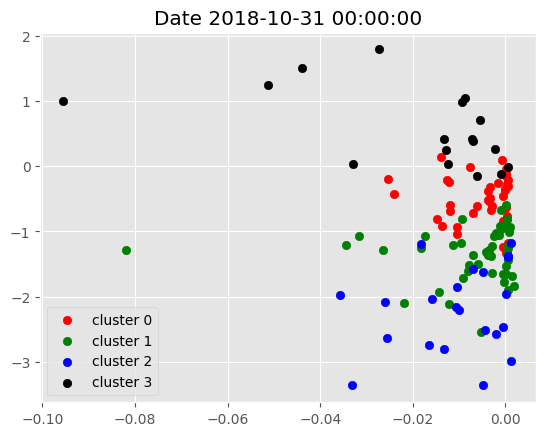

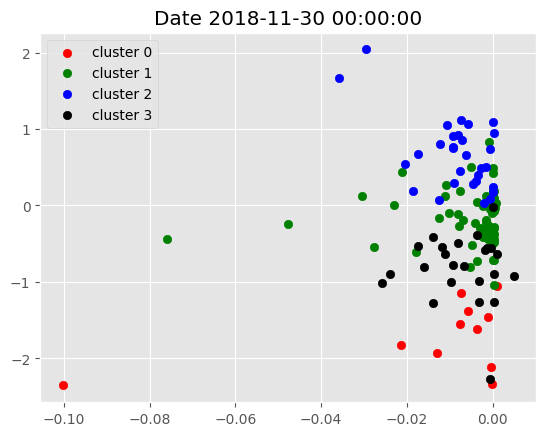

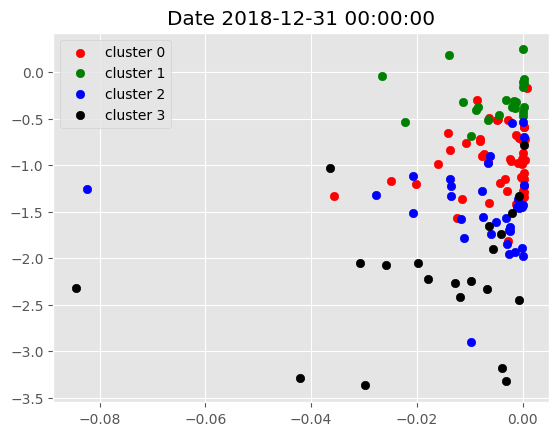

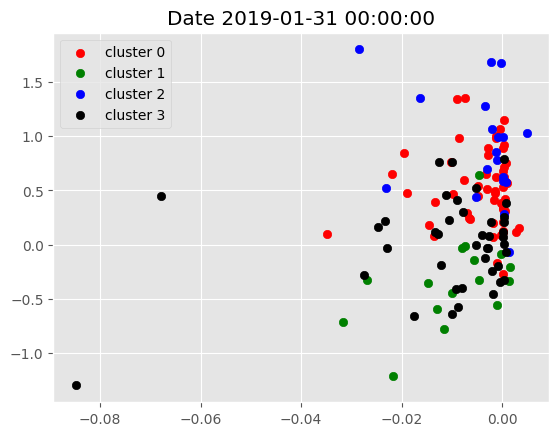

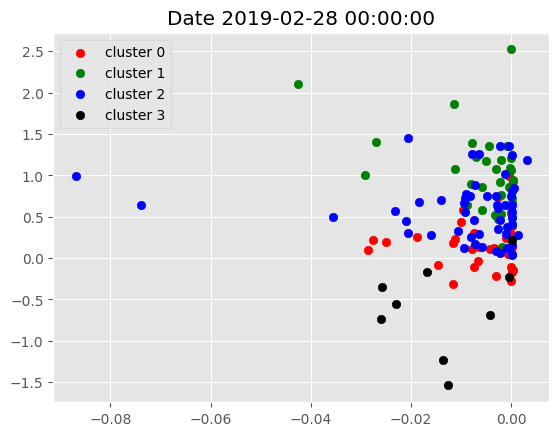

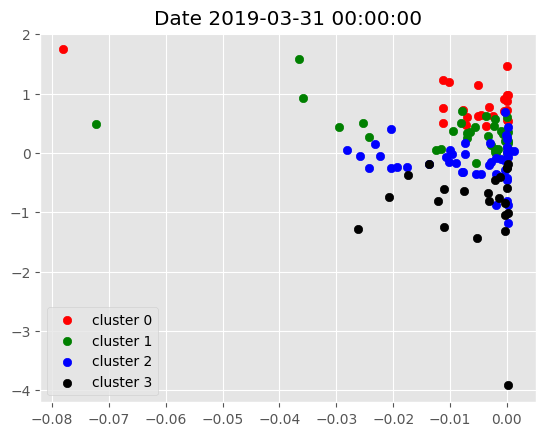

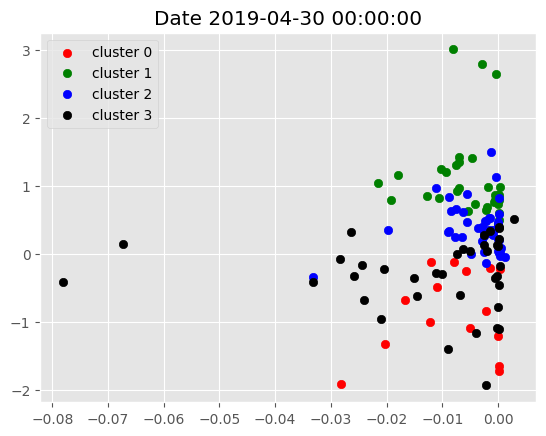

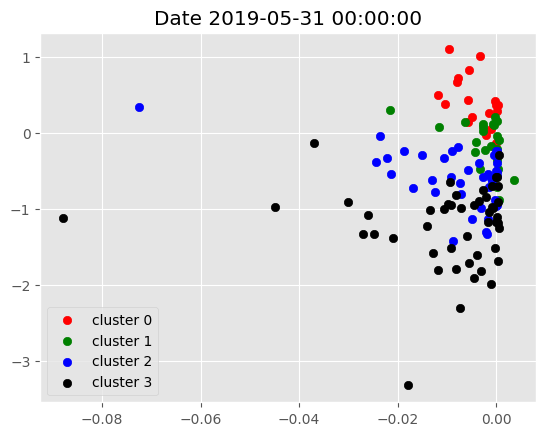

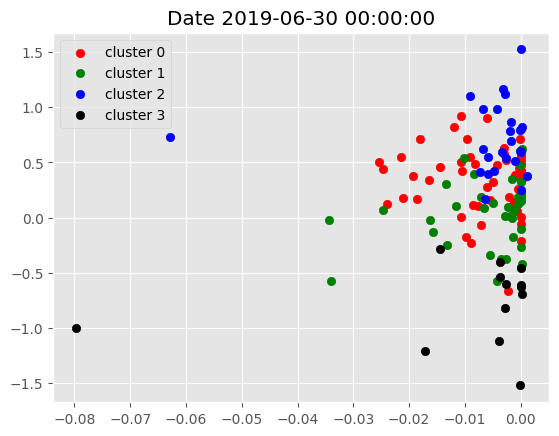

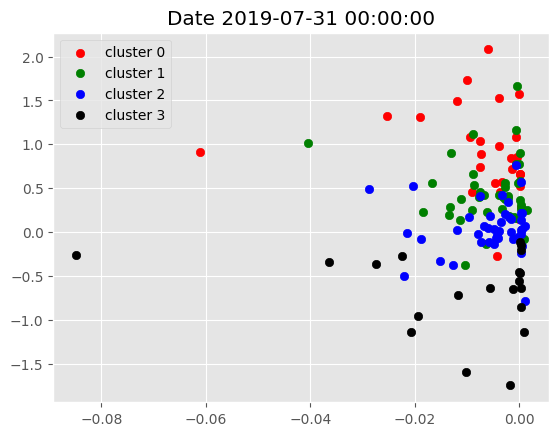

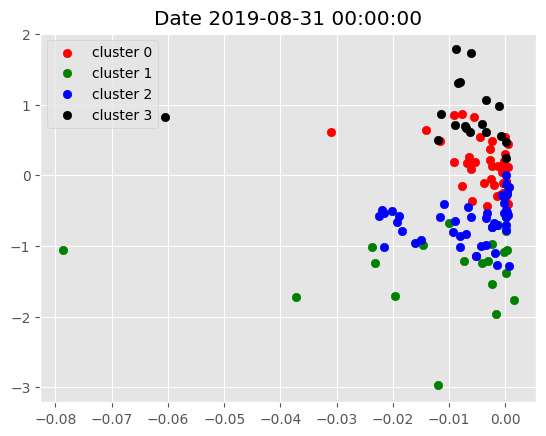

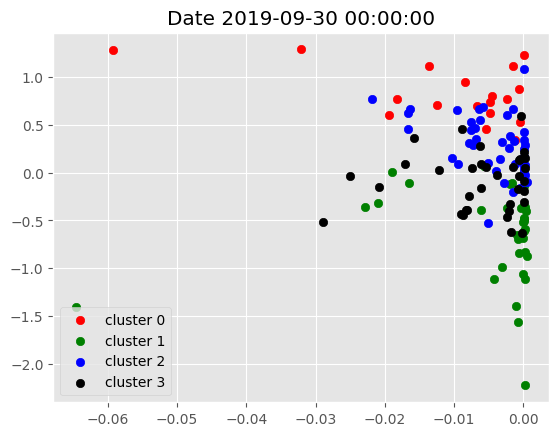

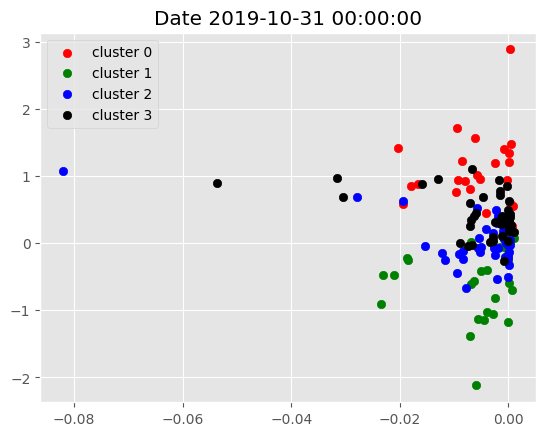

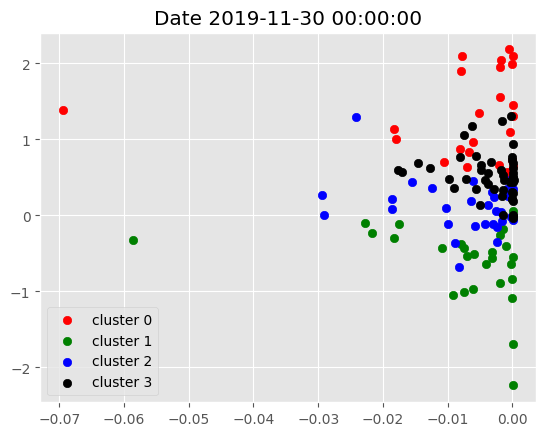

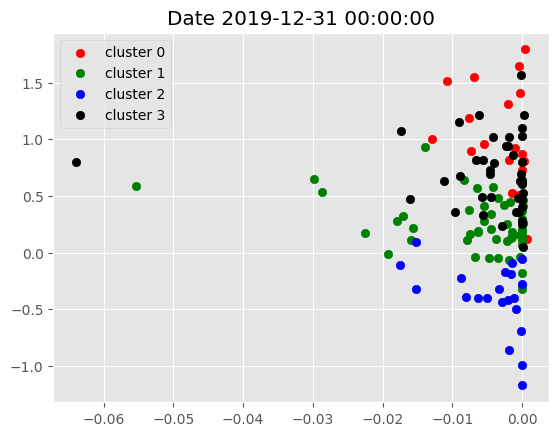

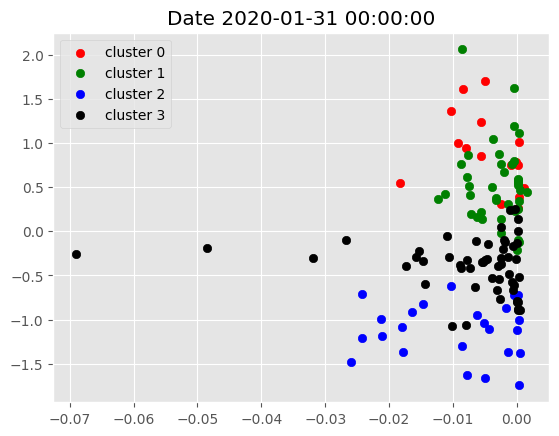

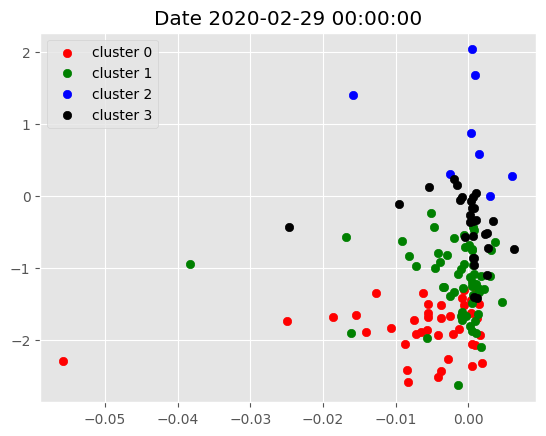

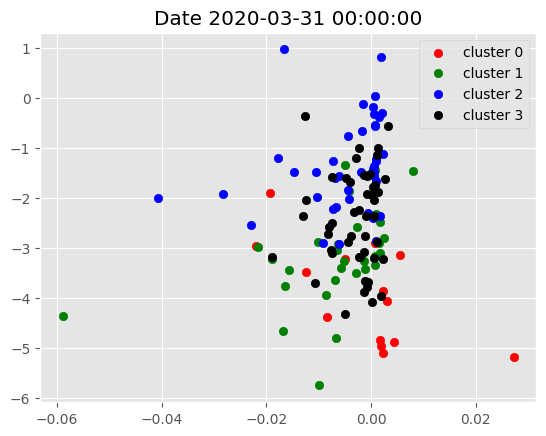

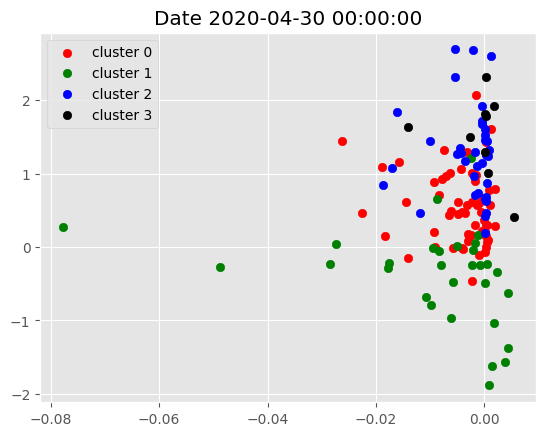

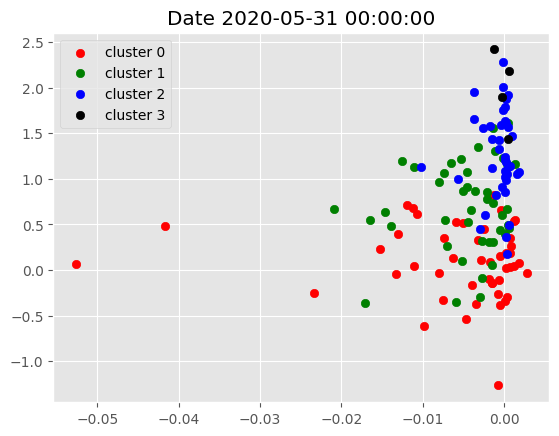

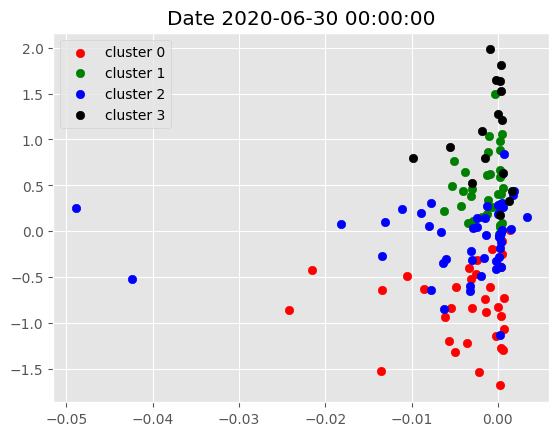

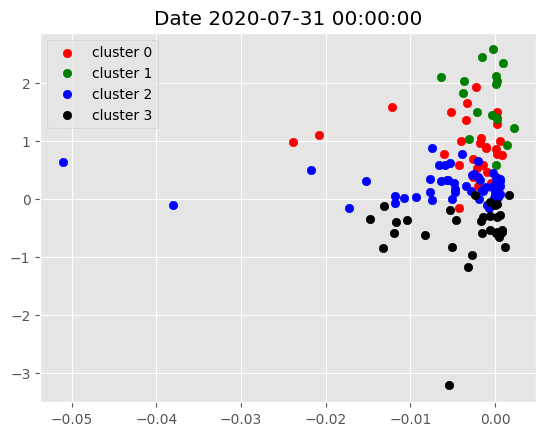

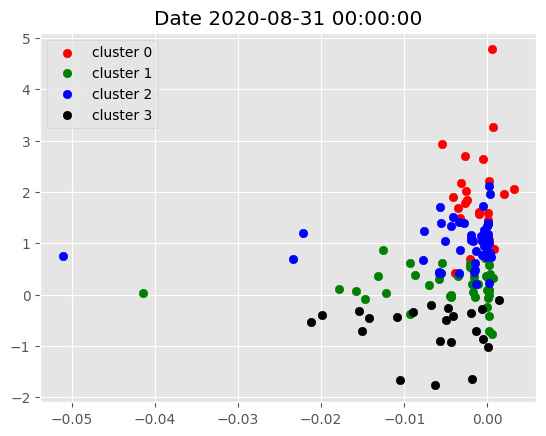

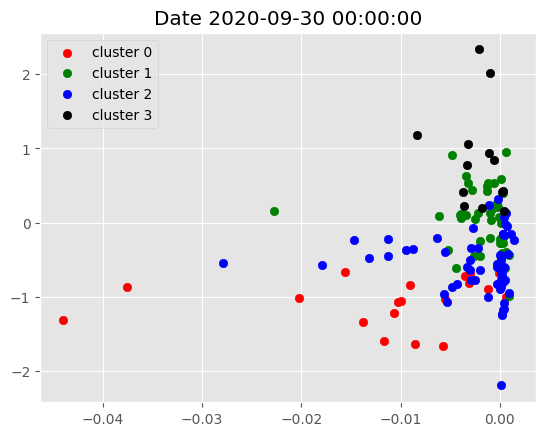

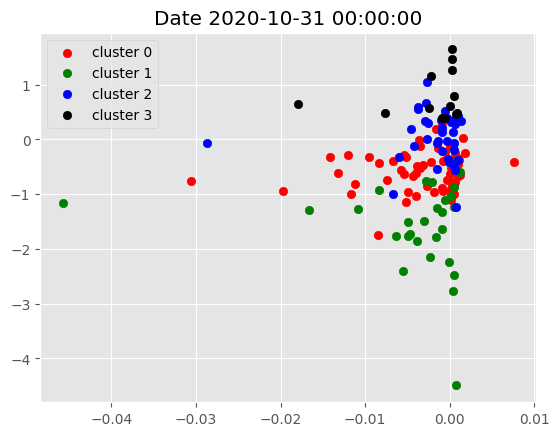

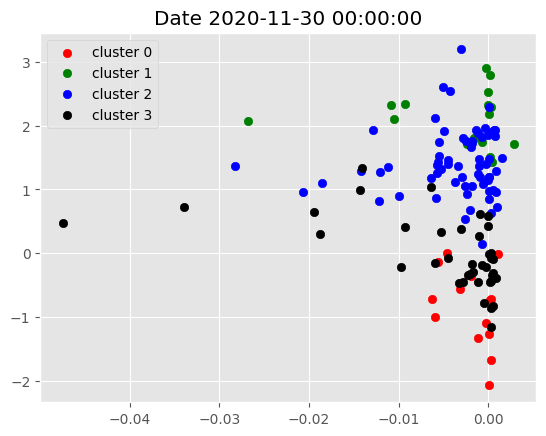

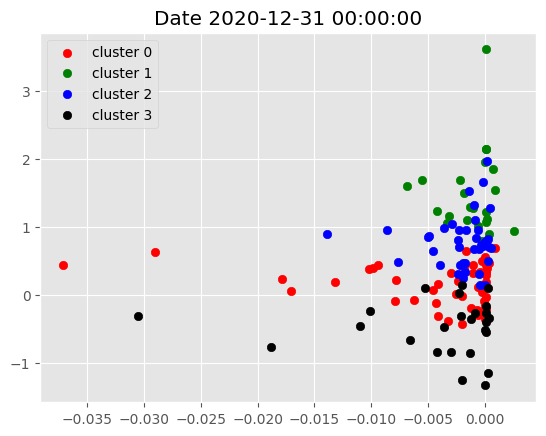

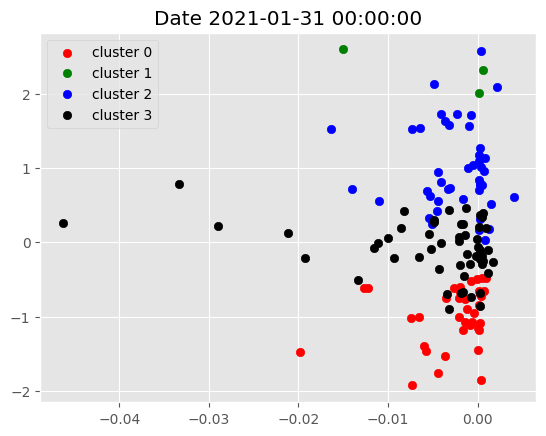

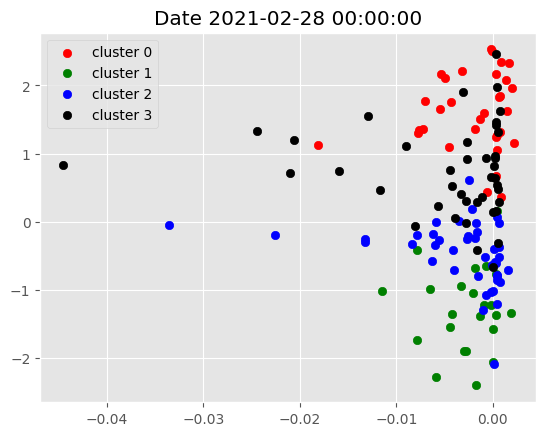

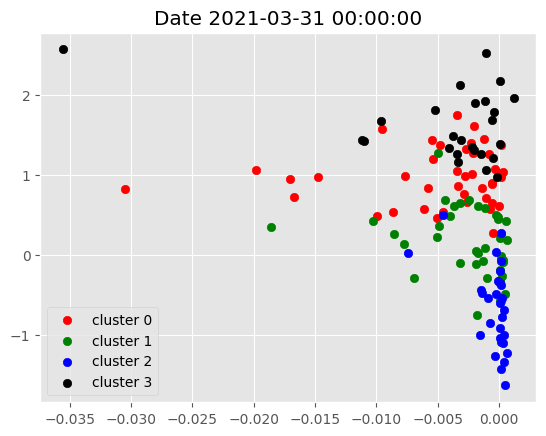

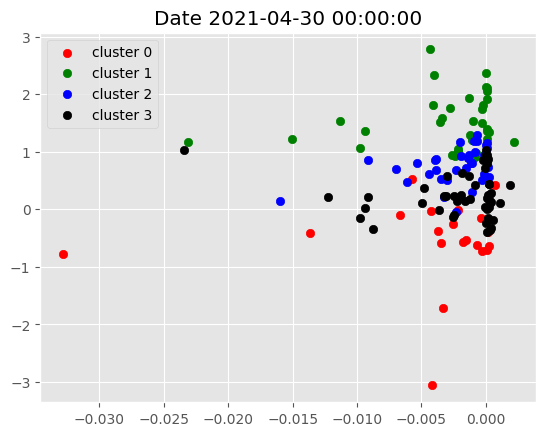

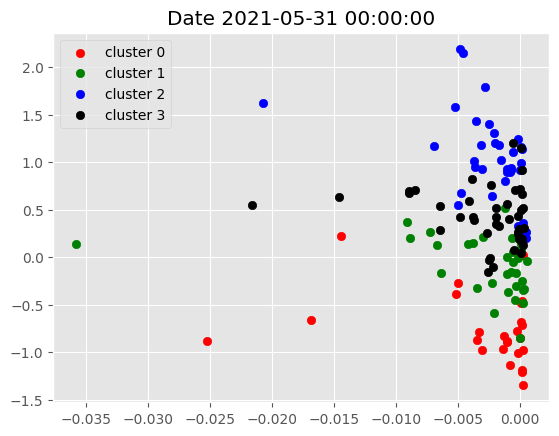

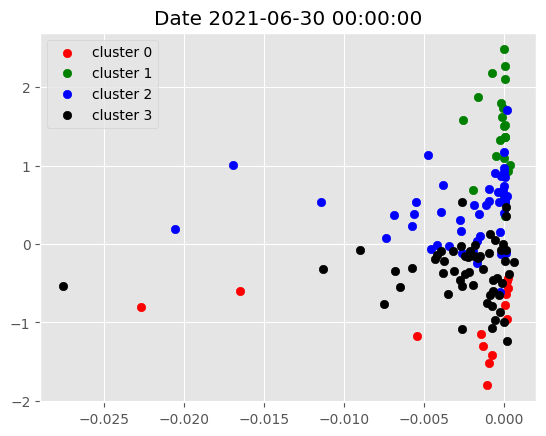

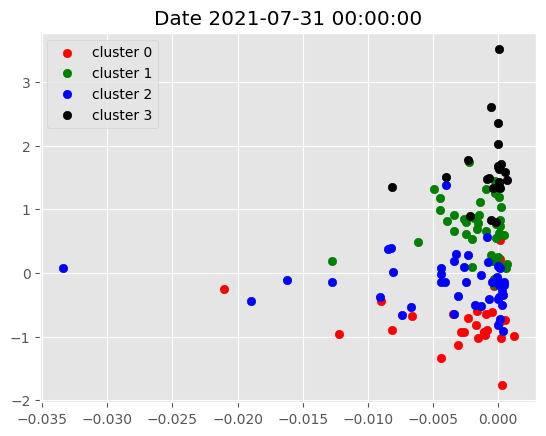

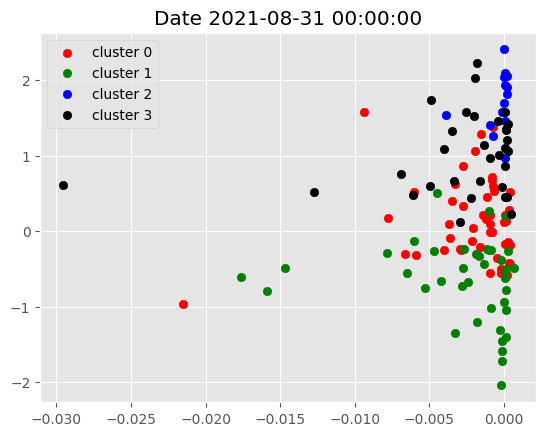

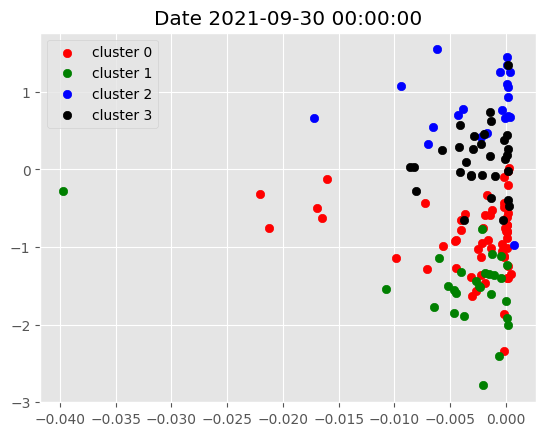

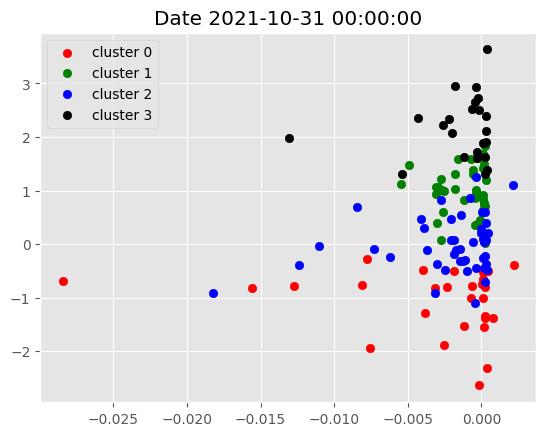

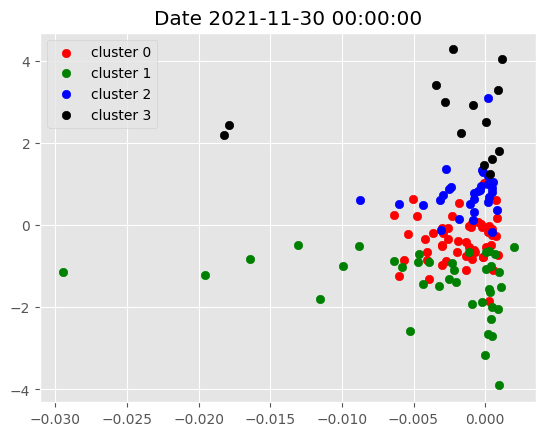

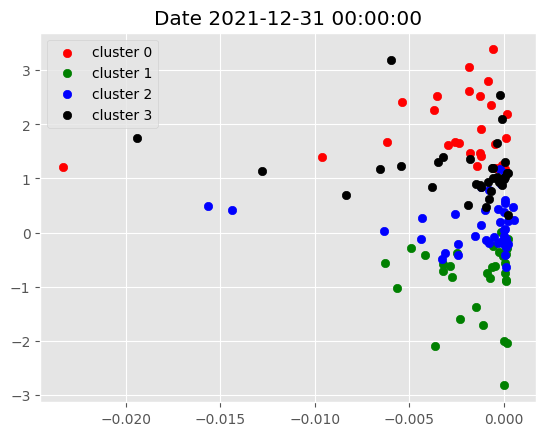

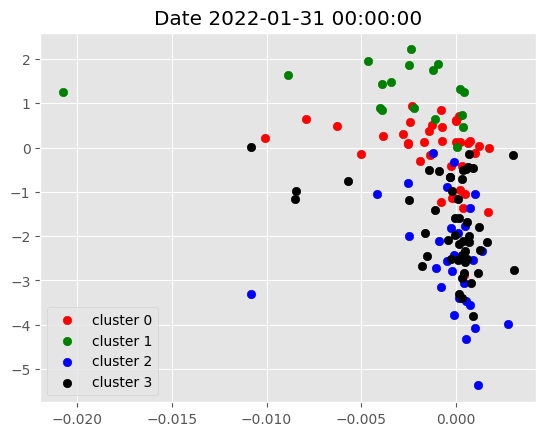

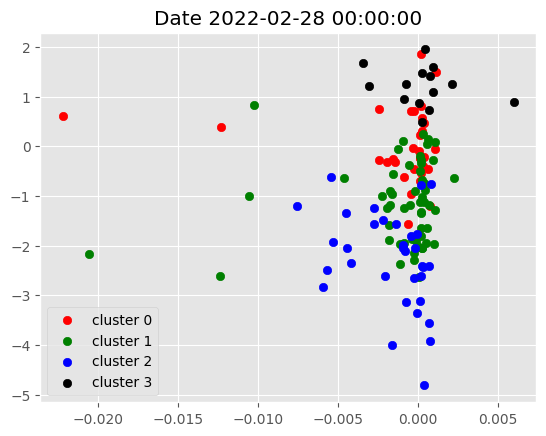

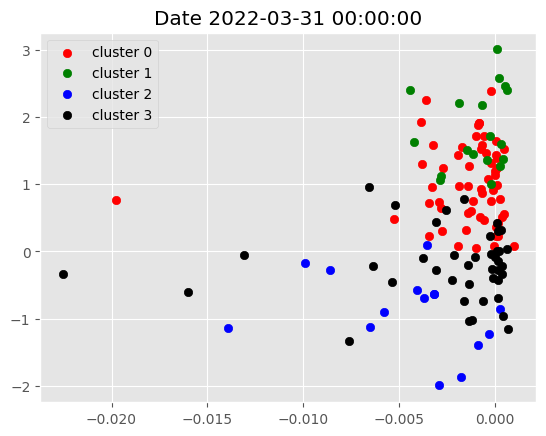

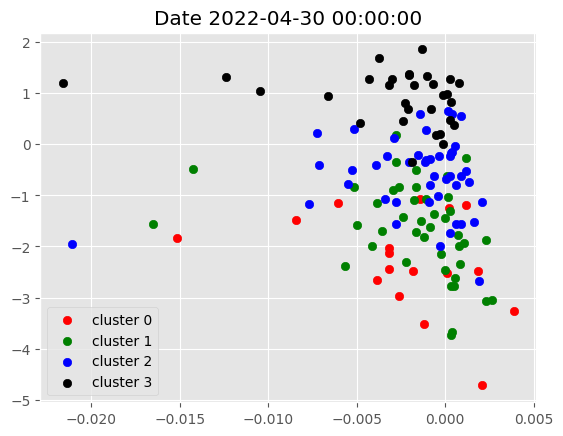

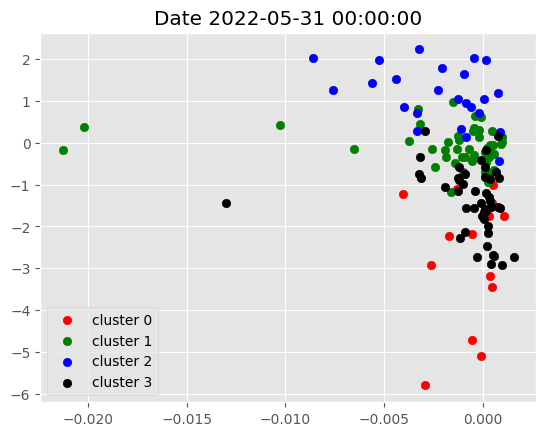

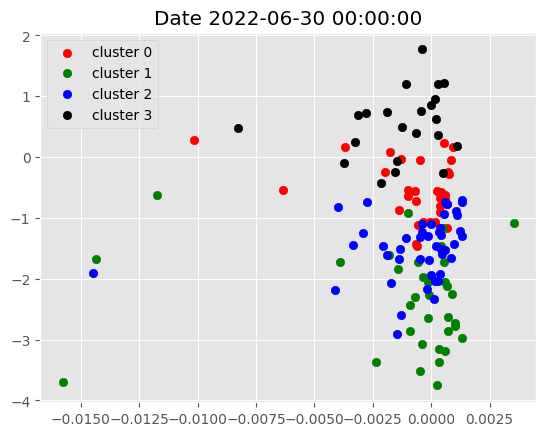

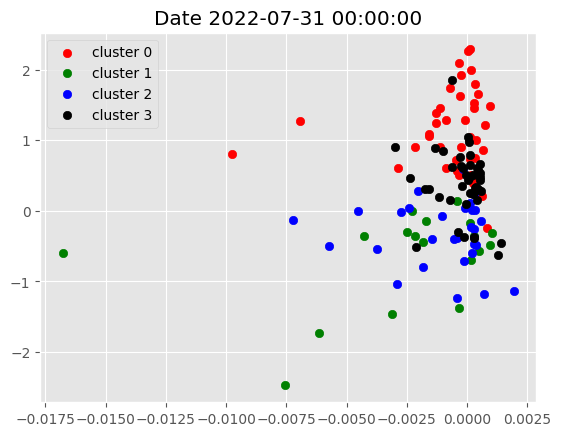

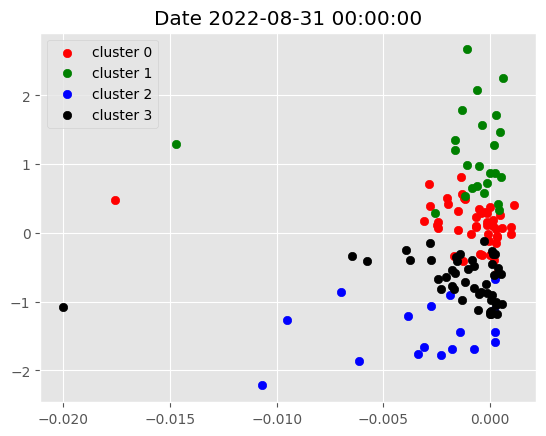

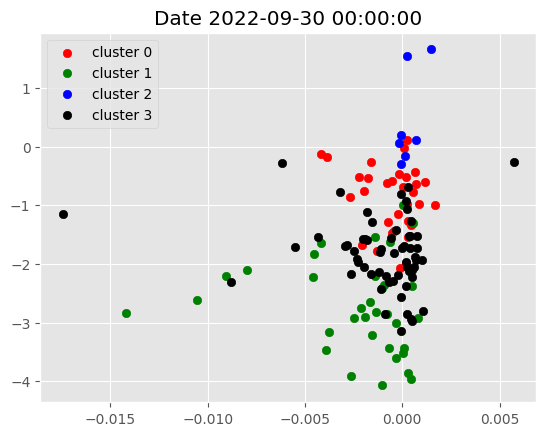

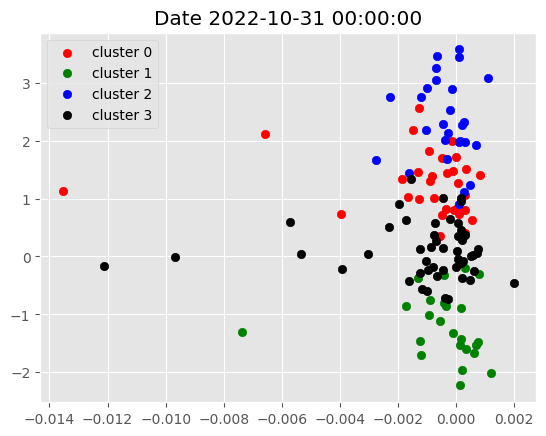

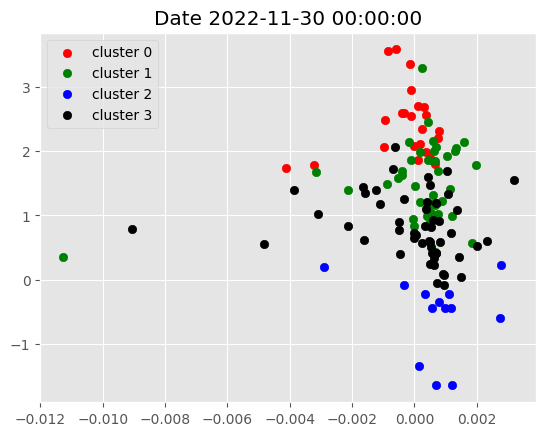

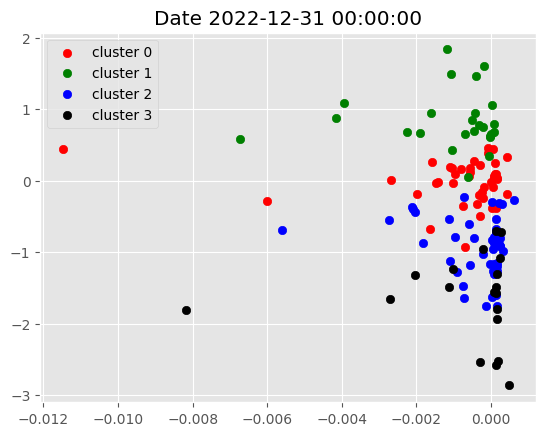

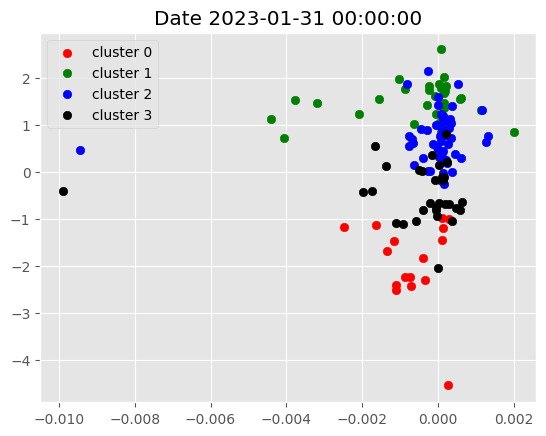

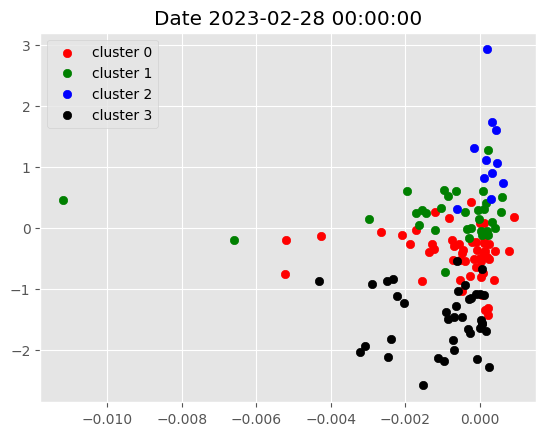

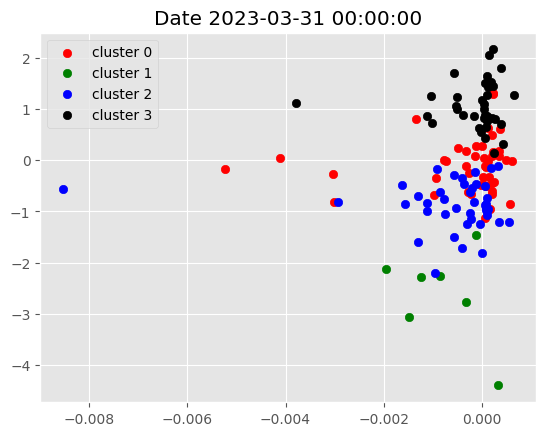

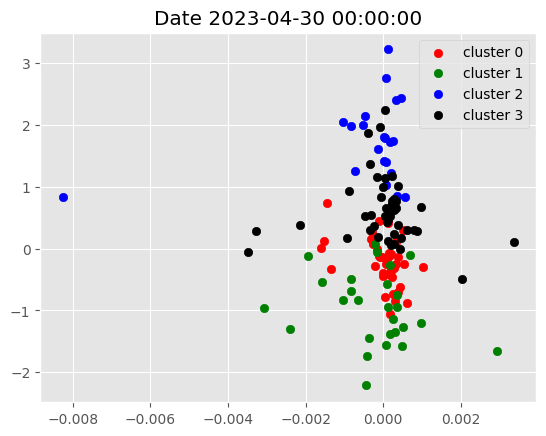

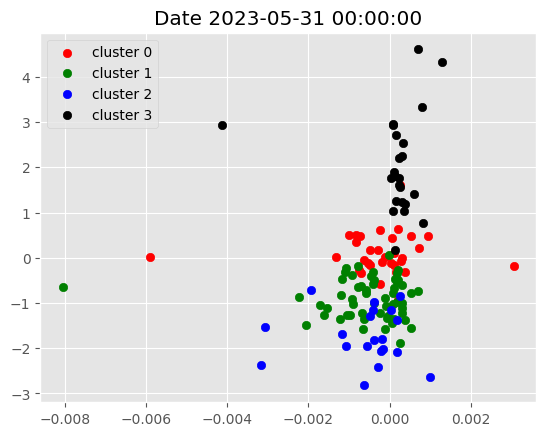

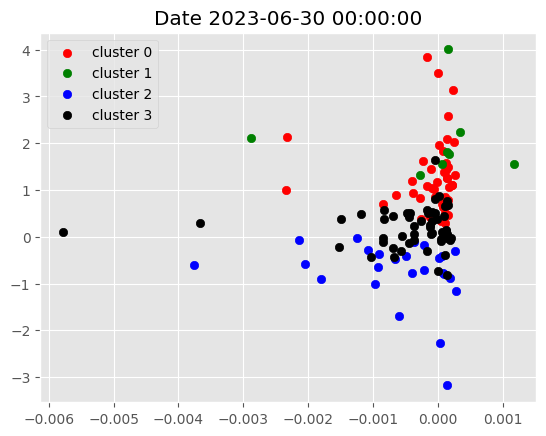

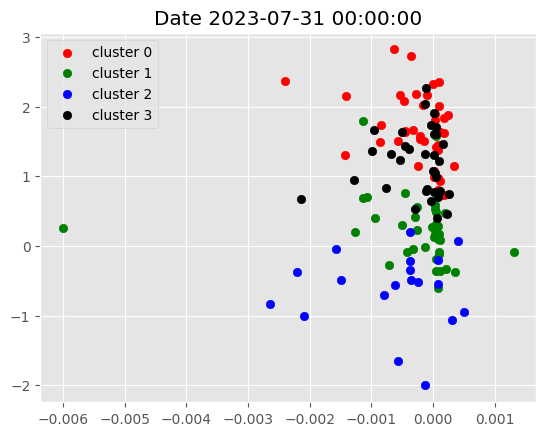

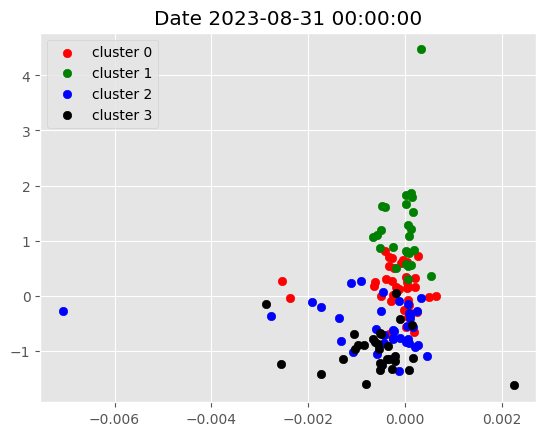

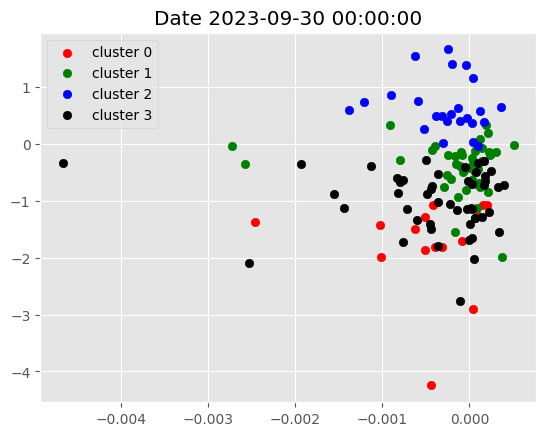

In [28]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [29]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [30]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-11-01': ['CMCSA',
  'DG',
  'F',
  'GM',
  'JNJ',
  'KO',
  'KR',
  'MCD',
  'MO',
  'MRK',
  'PG',
  'PM',
  'SBUX',
  'TSLA',
  'VZ',
  'WBA',
  'WMT'],
 '2018-12-01': ['AIG',
  'BMY',
  'C',
  'COP',
  'DD',
  'EOG',
  'IBM',
  'LMT',
  'LOW',
  'MAR',
  'MCK',
  'META',
  'MPC',
  'MS',
  'MU',
  'NFLX',
  'OXY',
  'PANW',
  'QCOM',
  'RTX',
  'SCHW',
  'STZ',
  'TJX',
  'WDC'],
 '2019-01-01': ['C',
  'CCL',
  'CVS',
  'EOG',
  'F',
  'FDX',
  'GS',
  'HAL',
  'LMT',
  'LUV',
  'MDLZ',
  'MO',
  'NVDA',
  'PM',
  'RTX',
  'SLB',
  'STZ',
  'USB',
  'WBA',
  'WDC',
  'XOM'],
 '2019-02-01': ['AAPL',
  'ACN',
  'BIIB',
  'BRK-B',
  'CAT',
  'CMCSA',
  'COP',
  'COST',
  'CSX',
  'CVX',
  'DIS',
  'EOG',
  'EXPE',
  'F',
  'FCX',
  'HAL',
  'ISRG',
  'JNJ',
  'JPM',
  'KO',
  'LOW',
  'MDT',
  'MO',
  'MRK',
  'MS',
  'MSFT',
  'NEE',
  'ORLY',
  'OXY',
  'PEP',
  'PFE',
  'PYPL',
  'RTX',
  'SLB',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'WFC',
  'WMT',
  'XOM'],
 '2019-03-01': ['AB

In [32]:
! pip install PyPortfolioOpt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 16.4 MB/s eta 0:00:00


In [33]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [34]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df


[*********************100%***********************]  143 of 143 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2017-10-31   39.624386   66.347000  48.011189  128.312424  175.160004   
2017-11-01   39.120415   67.956955  47.807564  128.853226  176.250000   
2017-11-02   39.406395   66.913048  48.135136  129.276840  180.940002   
2017-11-03   40.435452   67.861382  49.108997  129.826660  182.300003   
2017-11-06   40.845654   68.339233  48.701748  129.727509  180.800003   
...                ...         ...        ...         ...         ...   
2023-09-25  174.991043  147.717545  95.036842  310.686310  511.600006   
2023-09-26  170.896545  147.010712  93.827797  304.433167  506.299988   
2023-09-27  169.375977  146.265671  93.145264  308.128204  502.600006   
2023-09-28  169.634384  145.425140  95.670616  294.788849  504.670013   
2023-09-29  170.151169  142.378128  94.432312  301.002747  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2017-10-31   99.801422  124.959999  53.339542   52.079739   10.990000  ...   
2017-11-01   99.063164  124.779999  53.380833   51.415245   10.800000  ...   
2017-11-02   98.153214  124.720001  53.645008   51.922840   10.850000  ...   
2017-11-03   96.350517  124.849998  51.184837   52.190487   11.120000  ...   
2017-11-06   95.569321  123.820000  51.589367   51.987453   11.930000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  233.448486  205.669998  60.502197  135.559128   97.379997  ...   
2023-09-26  230.744583  201.660004  59.654991  133.068069   95.959999  ...   
2023-09-27  235.987045  202.279999  59.411537  134.040680   98.070000  ...   
2023-09-28  236.648407  207.889999  59.674465  137.176834  102.760002  ...   
2023-09-29  233.993149  206.910004  59.012283  137.405121  102.820000  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2017-10-31  3231000  2457100  15910000  12224700  1852600  5661000  14619200   
2017-11-01  4097800  2412600  11046600   9702600  1096400  3780000  11678300   
2017-11-02  4972900  2050000  13126900   8042600   763400  2605600  15630000   
2017-11-03  3390500  1884900   8038200  14066400  1098500  2942700  10049200   
2017-11-06  3326200  1608300  36443300   5949600  1073200  3084300  10414900   
...             ...      ...       ...       ...      ...      ...       ...   
2023-09-25  3241900   698100  17616900   6891000   894200  2685900  10624000   
2023-09-26  4936800   633600  18841600   7570500  1217300  3571100  15219400   
2023-09-27  3644000   860600  22083500  10182900  2338100  2547800  11815500   
2023-09-28  3587300   578900  18772100   7291500  9196300  3282000  12454600   
2023-09-29  4302200   896800  19759400  25659100  4066600  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-10-31  18020700  3938100   9754200  
2017-11-01  18528300  3463900   9430000  
2017-11-02  15549300  1357300   7775500  
2017-11-03  19536300  1213700   6903500  
2017-11-06  15772200  1772800   9276700  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1488 rows x 858 columns]

In [70]:
weights.stack().to_frame('weight').reset_index(level=0, drop=True)

,weight
AAPL,0.01000
ADP,0.01000
ADSK,0.01000
AMAT,0.04077
AMD,0.01000
AMZN,0.01000
AXP,0.01000
BAC,0.01000
BDX,0.01000
BLK,0.01000


In [83]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['level_0', 'weight']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
"None of ['level_0'] are in the columns"
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the columns"
"None of ['level_0'] are in the colu

""


In [84]:
temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)



temp_df


,Date,return,weight
Ticker,,,
